In [3]:
!pip install requests
!pip install selenium

In [49]:
import base64
import requests
import datetime
from urllib.parse import urlencode
from urllib.parse import urlparse
import webbrowser
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import config
import json
import csv

In [5]:
client_id = config.client_id
client_secret = config.client_secret

In [24]:
class SpotifyAPI():
    access_token = None
    access_token_expires = None
    access_token_did_expire = True
    client_id = None
    client_secret = None
    did_perform_grant_flow_auth = False
    authorize_url = "https://accounts.spotify.com/authorize"
    scope = None
    headers = None
    version = "v1"
    
    callback_url = None
    parts_of_callback_url = None
    
    
    def __init__(self, client_id, client_secret, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_id = client_id
        self.client_secret = client_secret
    
    def perform_auth_grant_flow(self):
        client_id = self.client_id
        authorize_url = self.authorize_url
        redirect_uri = "http://localhost:8888/callback"
        authorize_url = self.authorize_url
        scope = self.scope
        if scope is None:
            raise Exception("lack of scope, set permissions scope")
        
        parameters = urlencode({"client_id": client_id, "redirect_uri": redirect_uri, "response_type": "token", 
                                "scope": scope})
        request = requests.get(f"{authorize_url}?{parameters}")
        if request.status_code in range(200,299):
            driver = webdriver.Chrome("/usr/lib/chromium-browser/chromedriver")
            driver.get(f"{authorize_url}?{parameters}")
            try:
                WebDriverWait(driver, 60).until(EC.url_contains("access"))
            finally:
                url = driver.current_url
                driver.quit();
                self.callback_url = url
        else:
            raise Exception("failed to request")
    
    def get_callback_url(self):
        return self.callback_url
    
    def parse_redirected_url(self):
        url = self.callback_url
        
        if 'error' in url:
            raise Exception("user denied access")
            
        query = urlparse(url)[5]
        parts_of_callback_url = query.split('&')
    
        for i in range(len(parts_of_callback_url)):
            parts_of_callback_url[i] = parts_of_callback_url[i].split('=')[1]
        self.parts_of_callback_url = parts_of_callback_url
        
    def get_parts_of_redirected_url(self):
        return self.parts_of_callback_url
    
    def set_access_token_and_expire(self):
        self.access_token = self.parts_of_callback_url[0]
        expires_in_seconds = int(self.parts_of_callback_url[2])
        current_time = datetime.datetime.now()
        expires = current_time + datetime.timedelta(seconds=expires_in_seconds)
        self.token_expires = expires
        self.access_token_did_expire = expires < current_time
    
    def get_access_token(self):
        return self.access_token
    
    def get_expires(self):
        return self.token_expires
    
    ### different scopes must be space separated
    def set_scope(self, scope_string):
        self.scope = scope_string
        
    def get_scope(self):
        return self.scope
    
    def set_headers(self, access_token):
        self.headers = {
            "Accept": "application/json",
            "Content-Type": "application/json",
            "Authorization": f"Bearer {access_token}"
        }
        
    def get_headers(self):
        return self.headers
    
    def get_request(self, endpoint):
        headers = self.headers
        
        if headers is None:
            raise Exception("didn't set headers")
            
        r = requests.get(endpoint, headers=headers)
        
        if r.status_code == 204:
            raise Exception("No content in request")
            
        return r
    
    def get_current_user_playlists(self):
        
        if "playlist-read-private" not in self.scope:
            raise Exception("didn't find playlist-read-private in scope")
        
        version = self.version
        endpoint = f"https://api.spotify.com/{version}/me/playlists?limit=50"
        r = self.get_request(endpoint)
        
        return r.json()
    
    def get_playlists_ids(self, playlists_json):
        ids = []
        for item in playlists_json['items']:
            ids.append(item['id'])
        return ids
    
    def get_playlist_tracks(self, playlist_id):
        version = self.version
        endpoint = f"https://api.spotify.com/{version}/playlists/{playlist_id}/tracks"
        r = self.get_request(endpoint)
        return r.json()
    
    def get_tracks_artists_ids(self, tracks_json):
        ids = []
        for item in tracks_json['items']:
            ids.append(item['track']['artists'][0]['id'])
        return ids
    
    def get_artist(self, artist_id):
        version= self.version
        endpoint = f"https://api.spotify.com/{version}/artists/{artist_id}"
        r = self.get_request(endpoint)
        return r.json()
    
    #this way artists will repeat however, one artist mean one song because we can only get song genre
    #by getting artist data  
    def get_artists_name_and_genres(self, artists_ids):
        artists = []
        for item in artists_ids:
            artist_dict = {}
            artist = self.get_artist(item)
            
            if not artist['genres']:
                continue
            
            artist_dict[f"{artist['name']}"] = artist['genres']
            artists.append(artist_dict)
        return artists
    
    def get_all_artists_from_playlists(self, playlist_ids):
        artists_big_list = []
        for playlist_id in playlist_ids:
            tracks_json = self.get_playlist_tracks(playlist_id)
            artists_ids = self.get_tracks_artists_ids(tracks_json)
            artists = spotify.get_artists_name_and_genres(artists_ids)
            artists_big_list.append(artists)
        return artists_big_list

In [25]:
spotify = SpotifyAPI(client_id, client_secret);
spotify.set_scope("playlist-read-private")
spotify.perform_auth_grant_flow()

In [26]:
spotify.parse_redirected_url()
spotify.set_access_token_and_expire()
spotify.set_headers(spotify.get_access_token())

In [27]:
playlist_json = spotify.get_current_user_playlists();
playlist_ids = spotify.get_playlists_ids(playlist_json)
print(playlist_ids)

['2UA39JwqwiRSXHtfuGbGpk', '37i9dQZF1EttGlFRCrAVsG', '37i9dQZF1E9P2I7X5YoJ37', '37i9dQZF1EjniAoe8LUcSU', '63VZkiWGeT9aBwmSZtpymg', '37i9dQZF1ELZchLZzCHvOS', '5Q3z2p5TmCEdiGOW45VZnZ', '2cig4VycUu3V1FLotxciXE', '0XJDyY2UMcTnZZwRCaAWV4', '0ZBb59skaWIDwJHPFDV92a', '4WlYbStsVuSo4noLAL3kwX', '37i9dQZF1DWXo9v62EXLlM', '7abUEbx189e8lj57YkhMn3', '37i9dQZF1DWWEJlAGA9gs0', '37i9dQZF1DX2LTcinqsO68', '2FSTEf54NbWRZoXFKmxuIj', '01v0GcDMIML985JQs5QwgZ', '4nsNXKrmW9dhFeONFLaEe5', '5Yxx7cxBOoBmeMaMsjyS8C', '4blr5yafyFPhdyREKHQ4go', '37i9dQZF1DX4JAvHpjipBk', '6v0i58u43Xi5MHLS4AuMCa', '2X8xtgNR285fRPWpiXQEP0', '37i9dQZF1DWZeKCadgRdKQ', '05bouYSYuqwmMePAxw2qK3', '37i9dQZEVXcUW1YfiO3Qsa']


In [28]:
tracks_json = spotify.get_playlist_tracks(playlist_ids[0])
artists_ids = spotify.get_tracks_artists_ids(tracks_json)

print(artists_ids)

['3eM69n1zBUNhr7nsDLm5AH', '0MIG6gMcQTSvFbKvUwK0id', '28MEXbuN5228Ig7tTlyEpV', '0MIG6gMcQTSvFbKvUwK0id', '0MIG6gMcQTSvFbKvUwK0id', '4nPxrGG7k7aEKmNLsfX4cd', '4nPxrGG7k7aEKmNLsfX4cd', '4nPxrGG7k7aEKmNLsfX4cd']


In [29]:
artists_and_genres = spotify.get_all_artists_from_playlists(playlist_ids)

In [53]:
print(artists_and_genres)

[[{'Mata': ['polish hip hop', 'polish trap']}, {'Molesta': ['polish hip hop']}, {'Mata': ['polish hip hop', 'polish trap']}, {'Mata': ['polish hip hop', 'polish trap']}, {'White 2115': ['polish hip hop', 'polish trap']}, {'White 2115': ['polish hip hop', 'polish trap']}, {'White 2115': ['polish hip hop', 'polish trap']}], [{'Quiet Riot': ['album rock', 'classic rock', 'glam metal', 'hard rock', 'metal', 'rock']}, {'Metallica': ['hard rock', 'metal', 'old school thrash', 'rock', 'thrash metal']}, {'Metallica': ['hard rock', 'metal', 'old school thrash', 'rock', 'thrash metal']}, {'Black Sabbath': ['album rock', 'birmingham metal', 'classic rock', 'hard rock', 'metal', 'rock', 'stoner rock', 'uk doom metal']}, {'Metallica': ['hard rock', 'metal', 'old school thrash', 'rock', 'thrash metal']}, {'Metallica': ['hard rock', 'metal', 'old school thrash', 'rock', 'thrash metal']}, {'Diamond Head': ['album rock', 'hard rock', 'metal', 'nwobhm', 'rock', 'speed metal', 'thrash metal']}, {'Ozzy Os

In [32]:
artists_and_genres_merged = sum(artists_and_genres, [])

In [54]:
print(artists_and_genres_merged)

[{'Mata': ['polish hip hop', 'polish trap']}, {'Molesta': ['polish hip hop']}, {'Mata': ['polish hip hop', 'polish trap']}, {'Mata': ['polish hip hop', 'polish trap']}, {'White 2115': ['polish hip hop', 'polish trap']}, {'White 2115': ['polish hip hop', 'polish trap']}, {'White 2115': ['polish hip hop', 'polish trap']}, {'Quiet Riot': ['album rock', 'classic rock', 'glam metal', 'hard rock', 'metal', 'rock']}, {'Metallica': ['hard rock', 'metal', 'old school thrash', 'rock', 'thrash metal']}, {'Metallica': ['hard rock', 'metal', 'old school thrash', 'rock', 'thrash metal']}, {'Black Sabbath': ['album rock', 'birmingham metal', 'classic rock', 'hard rock', 'metal', 'rock', 'stoner rock', 'uk doom metal']}, {'Metallica': ['hard rock', 'metal', 'old school thrash', 'rock', 'thrash metal']}, {'Metallica': ['hard rock', 'metal', 'old school thrash', 'rock', 'thrash metal']}, {'Diamond Head': ['album rock', 'hard rock', 'metal', 'nwobhm', 'rock', 'speed metal', 'thrash metal']}, {'Ozzy Osbou

In [47]:
with open("artists_genres.csv", "w") as f:
    f.write("artist,genres" + '\n')
    for record in artists_and_genres_merged:
        line = "".join([str(key)+ "," + str(value) for key, value in record.items()]) + '\n'
        f.write(line)

AttributeError: '_io.TextIOWrapper' object has no attribute 'writerow'

In [56]:
w = csv.writer(open("artists_genres.csv", "w"), delimiter=',')
w.writerow(['artist', 'genres'])
for record in artists_and_genres_merged:
    for key, val in record.items():
        val = ','.join(val)
        w.writerow([key, val])

In [57]:
import pandas as pd

songs_data = pd.read_csv('artists_genres.csv')
print(songs_data)

          artist                                             genres
0           Mata                         polish hip hop,polish trap
1        Molesta                                     polish hip hop
2           Mata                         polish hip hop,polish trap
3           Mata                         polish hip hop,polish trap
4     White 2115                         polish hip hop,polish trap
...          ...                                                ...
1356       ESSEX                                               wave
1357      Jasiah  dark trap,emo rap,ohio hip hop,sad rap,undergr...
1358      Mareux                                     dark post-punk
1359    Amir Obe                      trap soul,underground hip hop
1360        Dwin               lithuanian edm,lithuanian electronic

[1361 rows x 2 columns]


In [91]:
genres_df = songs_data['genres'].str.split(',', expand=True).rename(columns = lambda x: "genre"+str(x+1))
print(genres_df)

              genre1                 genre2        genre3   genre4  \
0     polish hip hop            polish trap          None     None   
1     polish hip hop                   None          None     None   
2     polish hip hop            polish trap          None     None   
3     polish hip hop            polish trap          None     None   
4     polish hip hop            polish trap          None     None   
...              ...                    ...           ...      ...   
1356            wave                   None          None     None   
1357       dark trap                emo rap  ohio hip hop  sad rap   
1358  dark post-punk                   None          None     None   
1359       trap soul    underground hip hop          None     None   
1360  lithuanian edm  lithuanian electronic          None     None   

                   genre5     genre6 genre7 genre8 genre9 genre10 genre11  \
0                    None       None   None   None   None    None    None   
1    

In [126]:
genres_list = []
for col in genres_df:
    genres_list.append(genres_df[col].unique().tolist())

#removing duplicates
genres_list = list(set(sum(genres_list, [])))

In [134]:
def remove_none_elements_from_list(list):
    return [e for e in list if e != None]

genres_list = remove_none_elements_from_list(genres_list)

In [144]:
occurences = {}

for genre in genres_list:
    count = 0
    for genre_col in genres_df:
        count = count + (genres_df[genre_col] == genre).sum()
    occurences[genre] = count
    
sorted_occurences = {}
sorted_keys = sorted(occurences, key=occurences.get)

for key in sorted_keys:
    sorted_occurences[key] = occurences[key]
    
print(sorted_occurences)

{'jazz trumpet': 1, 'welsh rock': 1, 'edmonton indie': 1, 'screamo': 1, 'swiss black metal': 1, 'instrumental grime': 1, 'vocal house': 1, 'glitch': 1, 'british power metal': 1, 'tropical': 1, 'urbano espanol': 1, 'chill pop': 1, 'la pop': 1, 'sacramento indie': 1, 'bronx hip hop': 1, 'caucasian classical': 1, 'double drumming': 1, 'gospel r&b': 1, 'argentine ambient': 1, 'suomirap': 1, 'polish classical': 1, 'rap catala': 1, 'british choir': 1, 'uk post-punk': 1, 'gothic rock': 1, 'honky-tonk piano': 1, 'glitch hop': 1, 'country pop': 1, 'baltimore indie': 1, 'new york drill': 1, 'italian baroque': 1, 'christian rock': 1, 'german alternative rock': 1, 'jazz boom bap': 1, 'heartland rock': 1, 'exotica': 1, 'hip house': 1, 'florida rap': 1, 'country': 1, 'reggae fusion': 1, 'gothenburg metal': 1, 'post-screamo': 1, 'london rap': 1, 'rap conscient': 1, 'jazz fusion': 1, 'pop reggaeton': 1, 'disco house': 1, 'folk rock': 1, 'old school hip hop': 1, 'trap argentino': 1, 'viking metal': 1, 

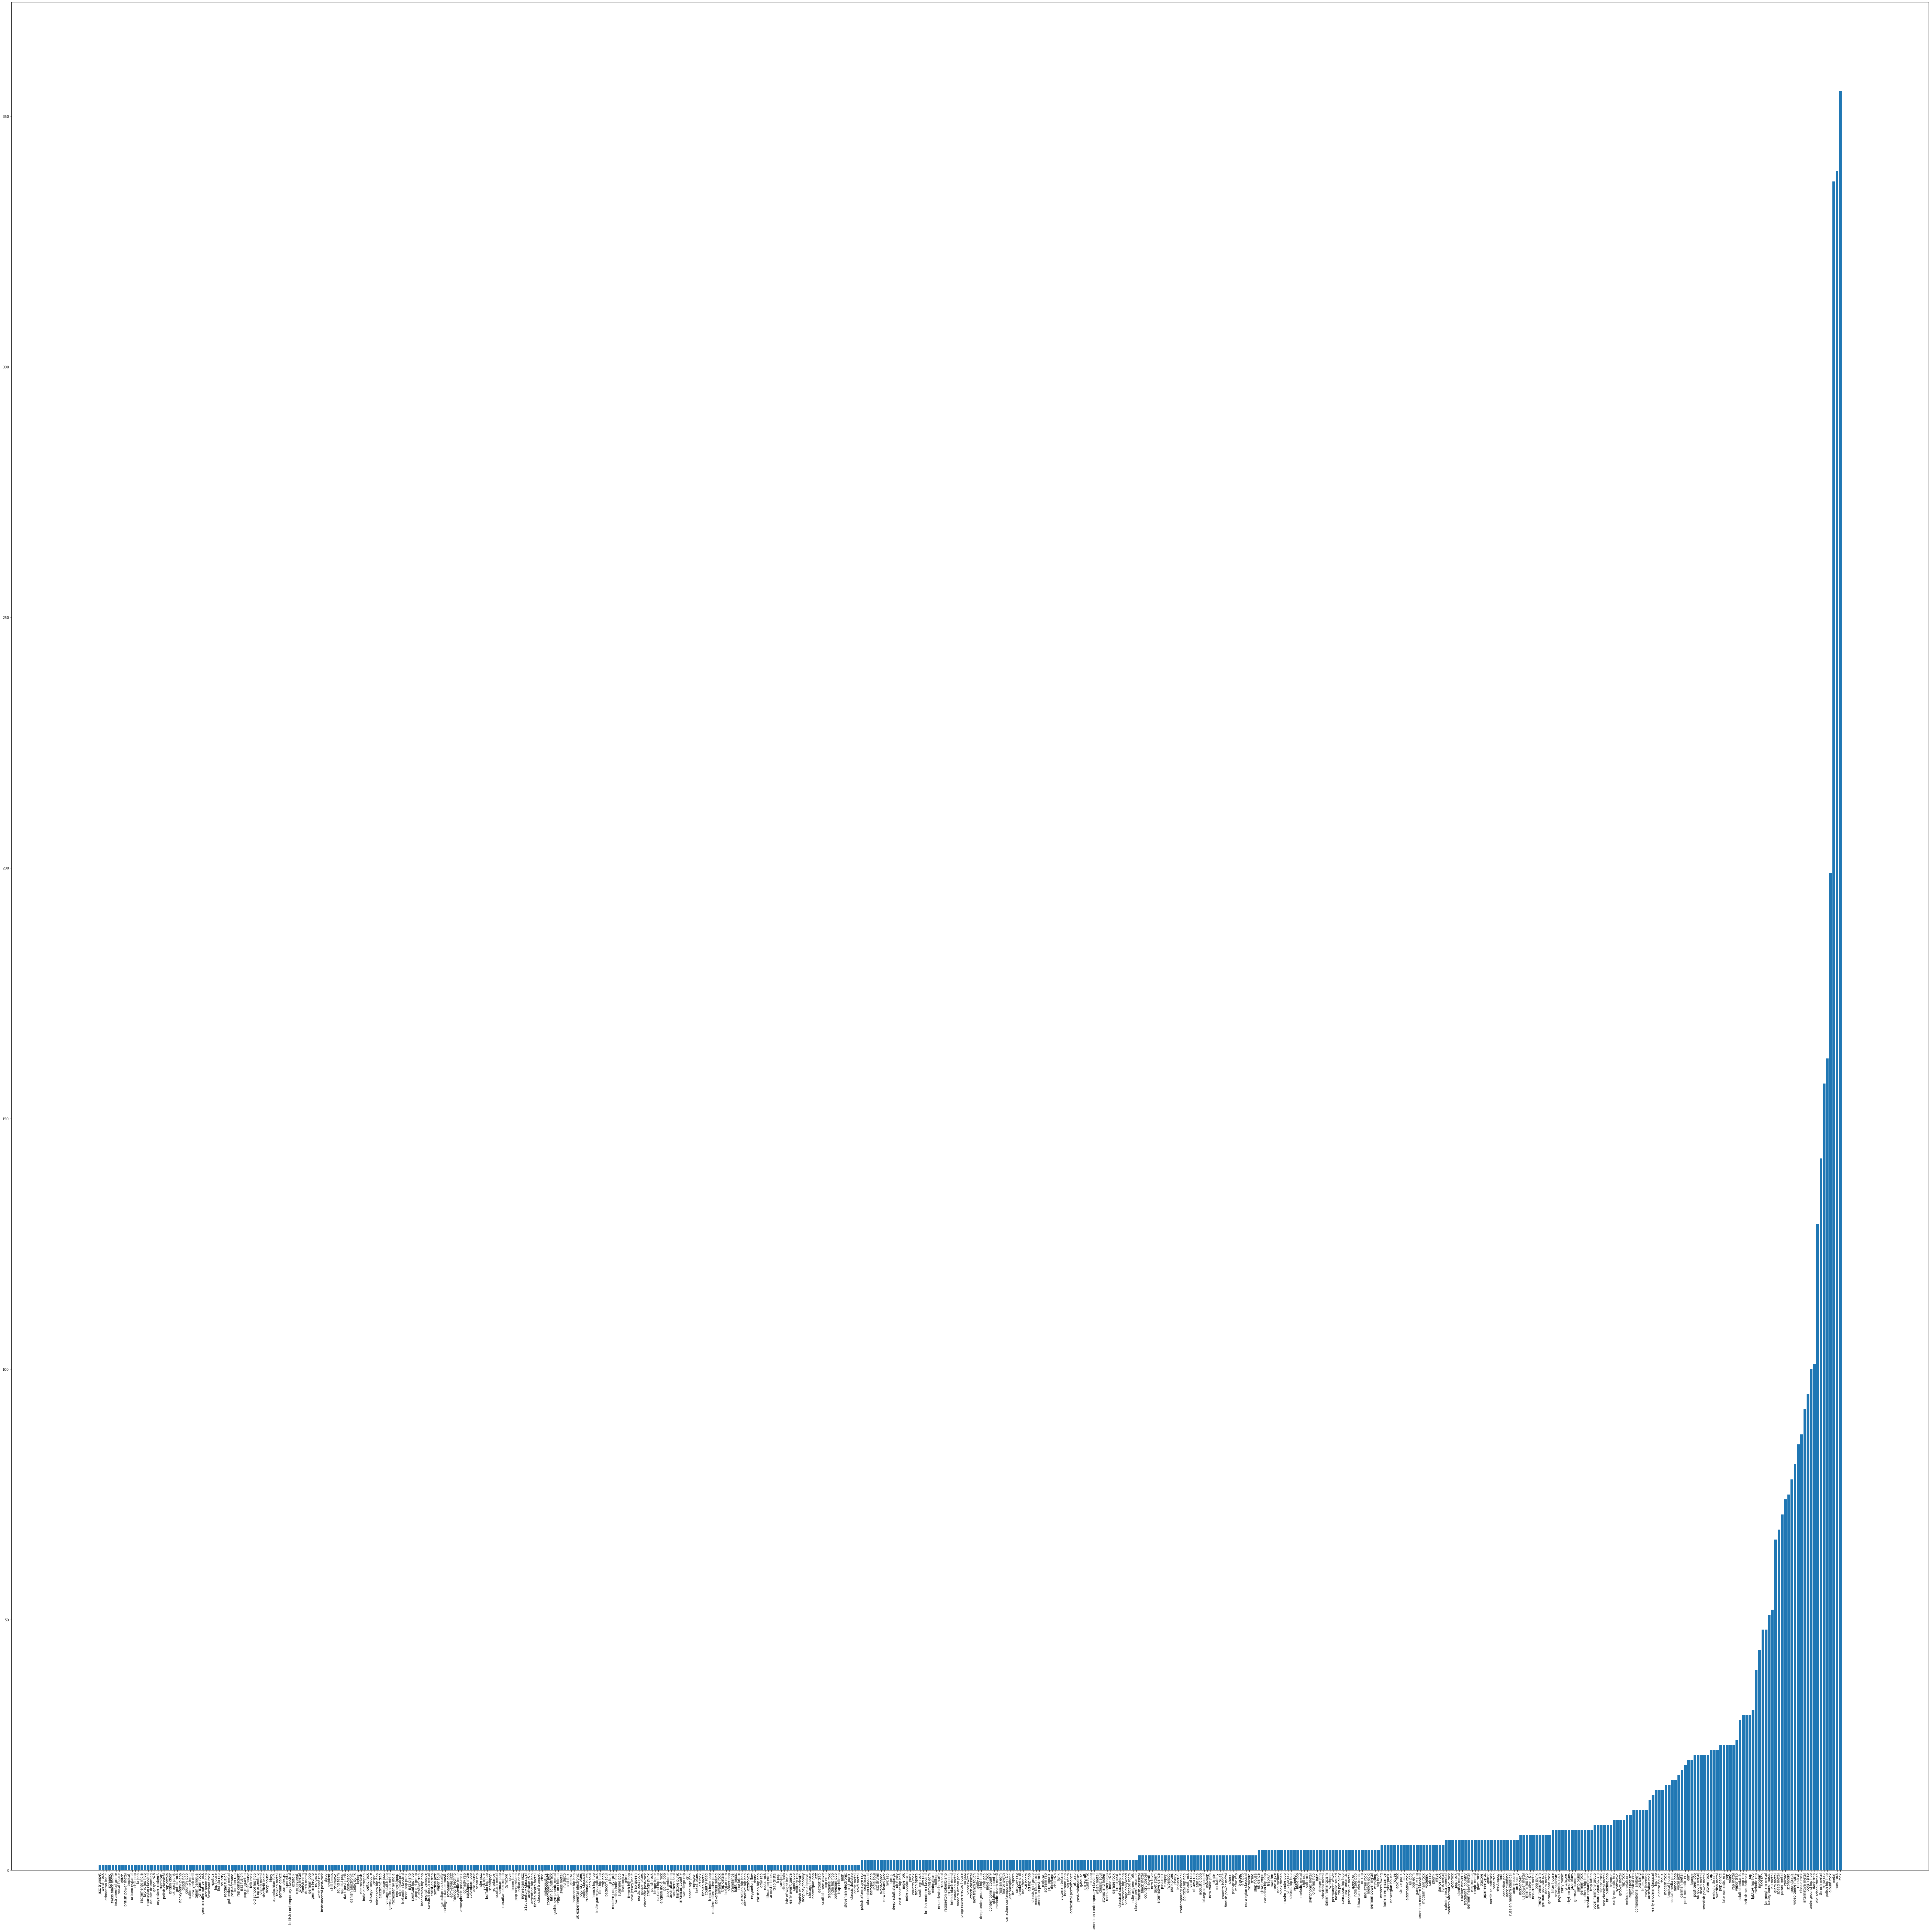

In [146]:
import matplotlib.pyplot as plt

plt.figure(figsize=(100,100))
plt.xticks(rotation='vertical')
plt.bar(*zip(*sorted_occurences.items()))
plt.show
plt.savefig('result.png')